In [1]:
try:
    from IPython.display import Image, display
except Exception:
    class Image:
        def __init__(self, filename, **kwargs):
            self.filename = filename
        def __repr__(self):
            return f"<Image {self.filename}>"
    def display(obj):
        try:
            print(f"[Image] {obj.filename}")
        except Exception:
            print(obj)


In [2]:
import os
try:
    from IPython.display import SVG
except Exception:
    SVG = None

def show_image(path):
    full = os.path.join('..', 'figures', path) if not os.path.isabs(path) else path
    if os.path.exists(full):
        ext = os.path.splitext(full)[1].lower()
        try:
            if ext == '.svg' and SVG is not None:
                # embed SVG text
                with open(full, 'r', encoding='utf-8') as f:
                    svg_text = f.read()
                display(SVG(data=svg_text))
            else:
                # embed raster image bytes
                with open(full, 'rb') as f:
                    img_bytes = f.read()
                display(Image(data=img_bytes))
        except Exception:
            try:
                display(Image(filename=full))
            except Exception:
                print(f"[Image available] {full}")
    else:
        print(f"[Image missing] {full}")


**Generated artefacts (auto-listed)**

The cell below scans the `../figures/` directory and prints the image and CSV artefacts that are present when the notebook runs. This keeps the report in sync with workspace outputs.


In [1]:
import os
import glob

fig_path = os.path.join('..', 'figures')

print(f"Looking for artefacts in: {fig_path}\n")
if os.path.isdir(fig_path):
    files = sorted(glob.glob(os.path.join(fig_path, '**', '*.*'), recursive=True))
    images = [p for p in files if p.lower().endswith(('.png', '.svg', '.jpg', '.jpeg', '.gif'))]
    csvs = [p for p in files if p.lower().endswith('.csv')]

    if images:
        print('Figures:')
        for p in images:
            print(' -', p)
    else:
        print('No image files found under ../figures/')

    if csvs:
        print('\nCSV outputs:')
        for p in csvs:
            print(' -', p)
    else:
        print('\nNo CSV files found under ../figures/')
else:
    print(f'No {fig_path} directory found. Check relative paths.')


Looking for artefacts in: ..\figures

Figures:
 - ..\figures\histogram_price.png
 - ..\figures\histogram_price.svg
 - ..\figures\pv_mod1_before_after.png
 - ..\figures\pv_mod1_before_after.svg
 - ..\figures\scatter_demand_vs_temperature.png
 - ..\figures\scatter_demand_vs_temperature.svg
 - ..\figures\task11_figures\task11_battery.png
 - ..\figures\task11_figures\task11_battery.svg
 - ..\figures\task11_figures\task11_cumulative_cost.png
 - ..\figures\task11_figures\task11_cumulative_cost.svg
 - ..\figures\task11_figures\task11_demand_pv.png
 - ..\figures\task11_figures\task11_demand_pv.svg
 - ..\figures\task11_figures\task11_grid.png
 - ..\figures\task11_figures\task11_grid.svg
 - ..\figures\task11_figures\task11_price.png
 - ..\figures\task11_figures\task11_price.svg
 - ..\figures\task11_figures\task11_soc.png
 - ..\figures\task11_figures\task11_soc.svg
 - ..\figures\task11_figures\task11_total_cost.png
 - ..\figures\task11_figures\task11_total_cost.svg
 - ..\figures\task5_histogram_d

## Task 4: Missing Data Analysis

Analyze and impute missing PV data.

### Key Java Implementation (PvMod1Imputation.java)

```java
public static ImputationResult runAll(List<DataRow> rows, PvTask4Config cfg) {
    // ...
    var uni = UnivariateImputation.interpolate(original);
    var multi = MultivariateImputation.impute(original, weather, cfg);
    return new ImputationResult(original, uni, multi);
}
```

Task 4: PV Imputation Results


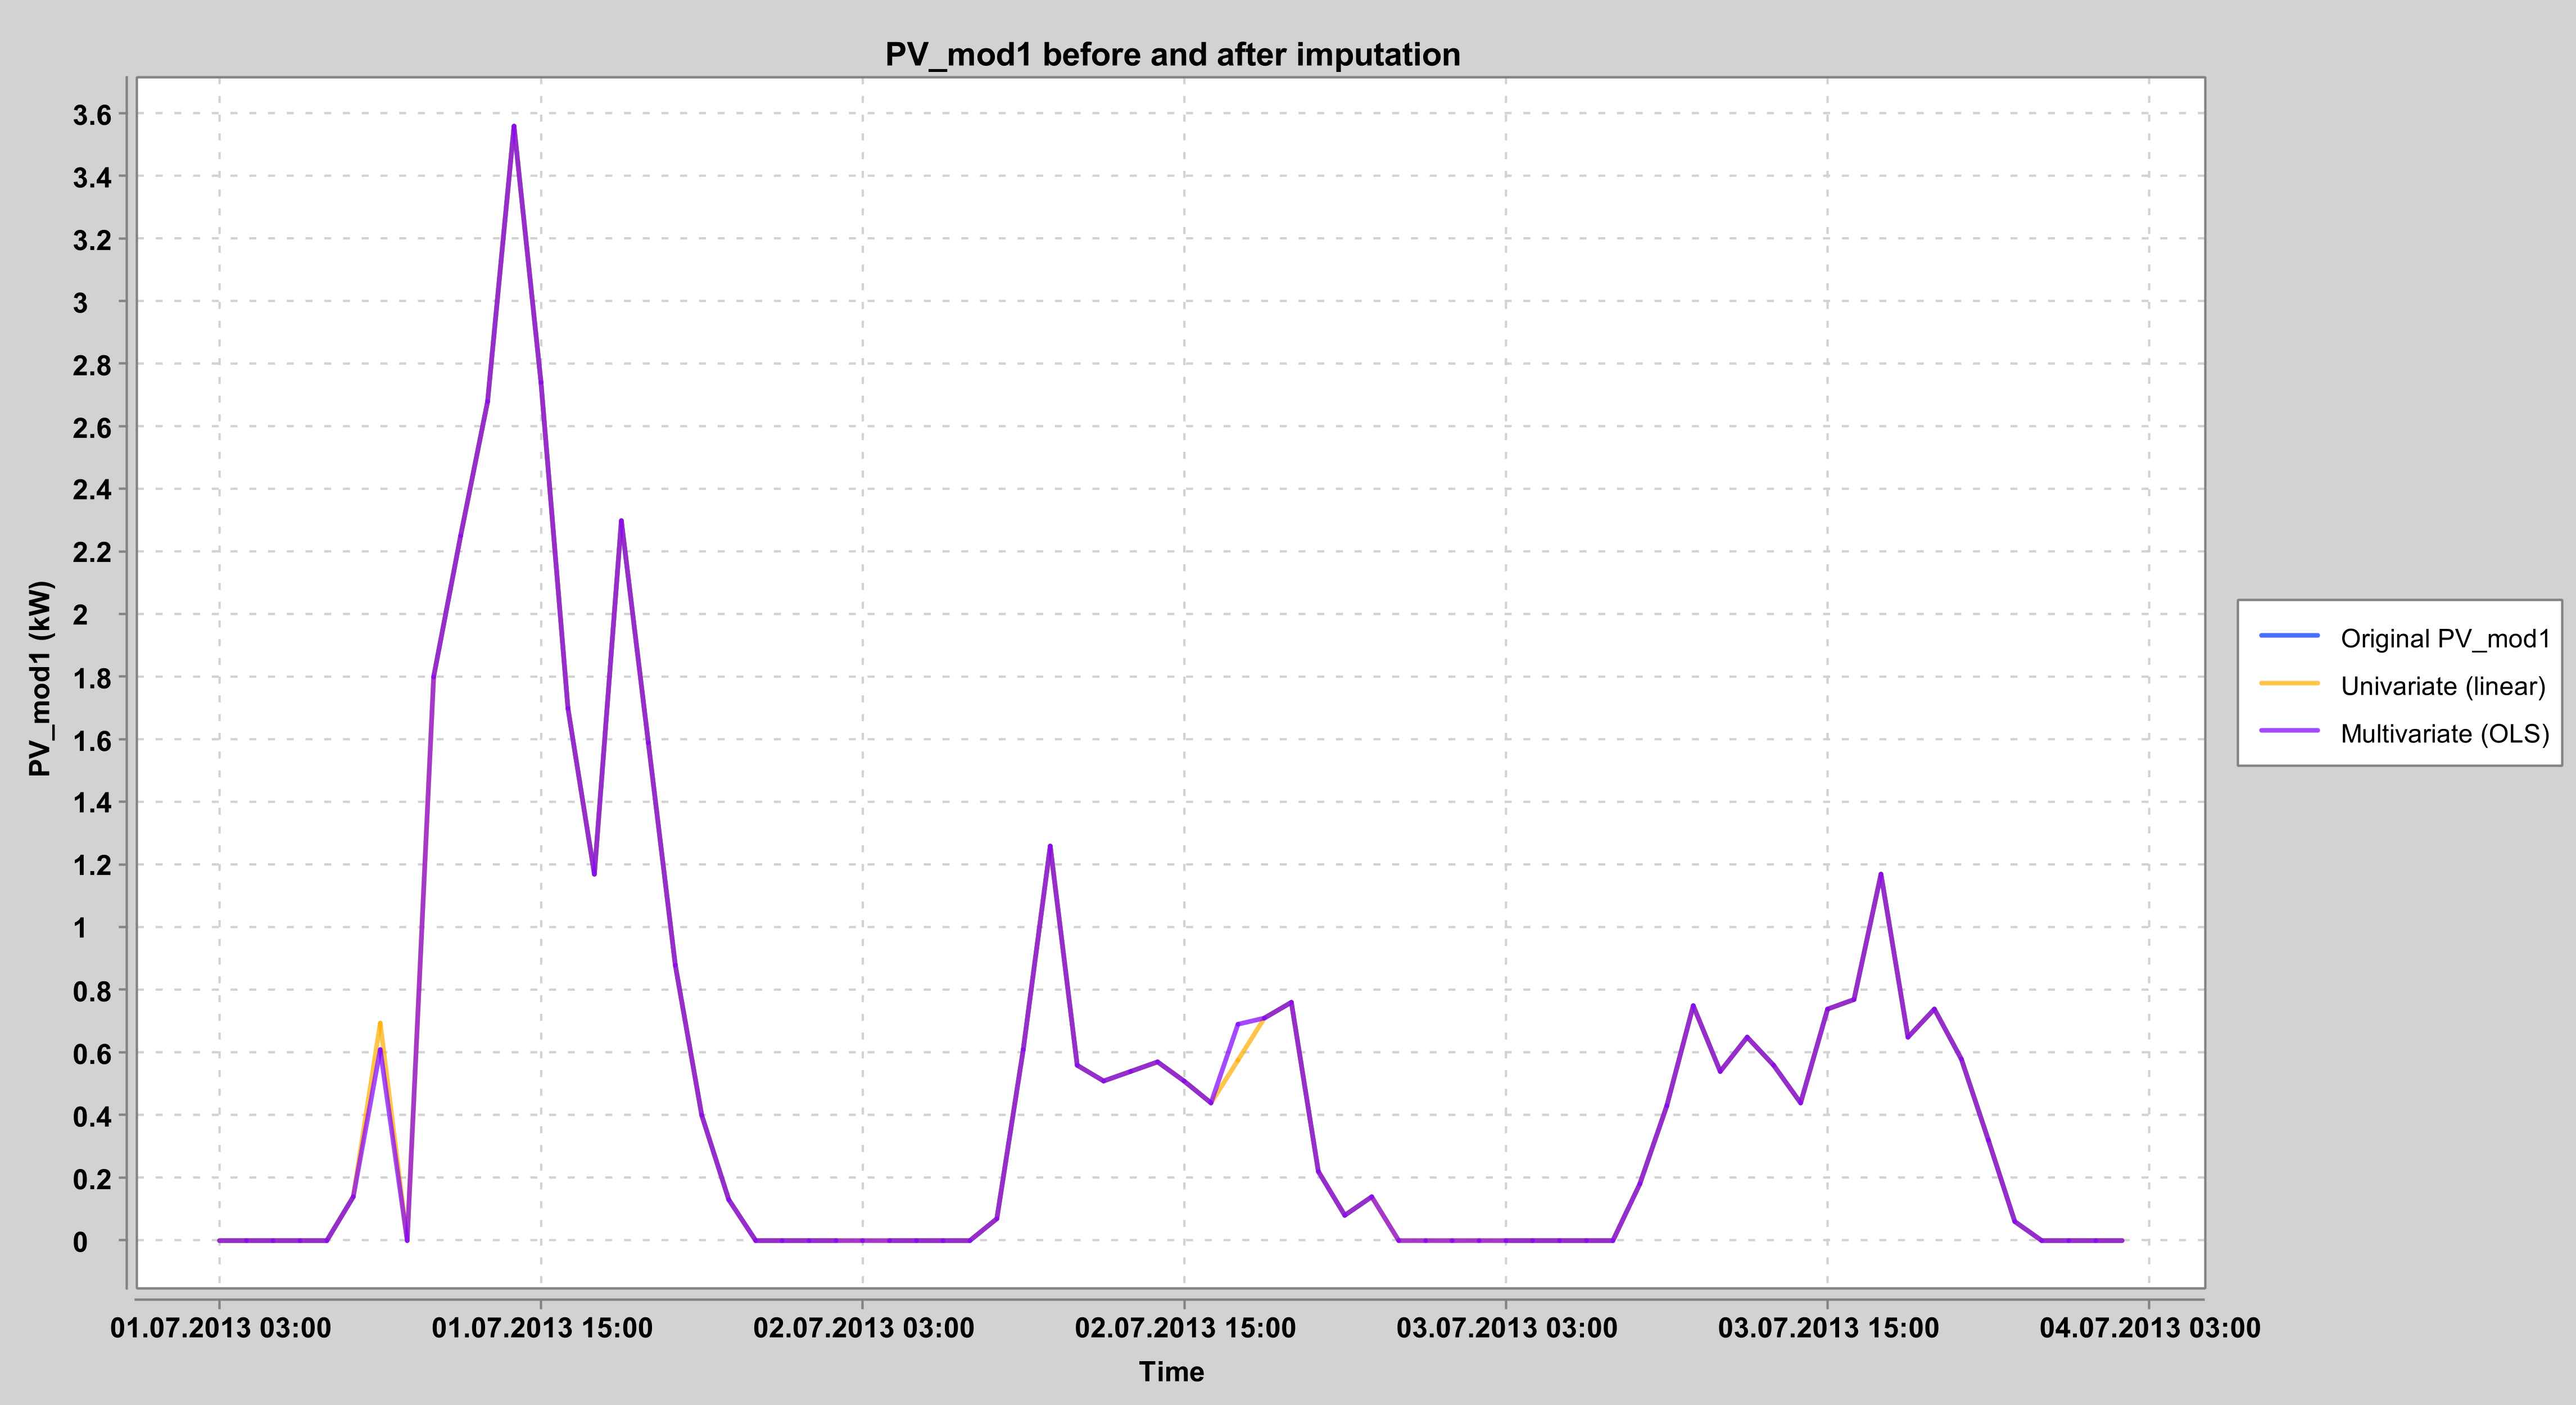

In [4]:
print("Task 4: PV Imputation Results")
show_image('task4_pv_mod1_before_after.png')

## Task 5: Feature Engineering

Normality checks and feature ranking.

### Key Java Implementation (FeatureRanking.java)

```java
public static List<FeatureScore> rankByAbsPearson(Dataset ds) {
    // ...
    var corr = new PearsonsCorrelation();
    double r = corr.correlation(featVec, targetVec);
    scores.add(new FeatureScore(name, Math.abs(r)));
    // ...
    return scores;
}
```

Task 5: Demand Histogram


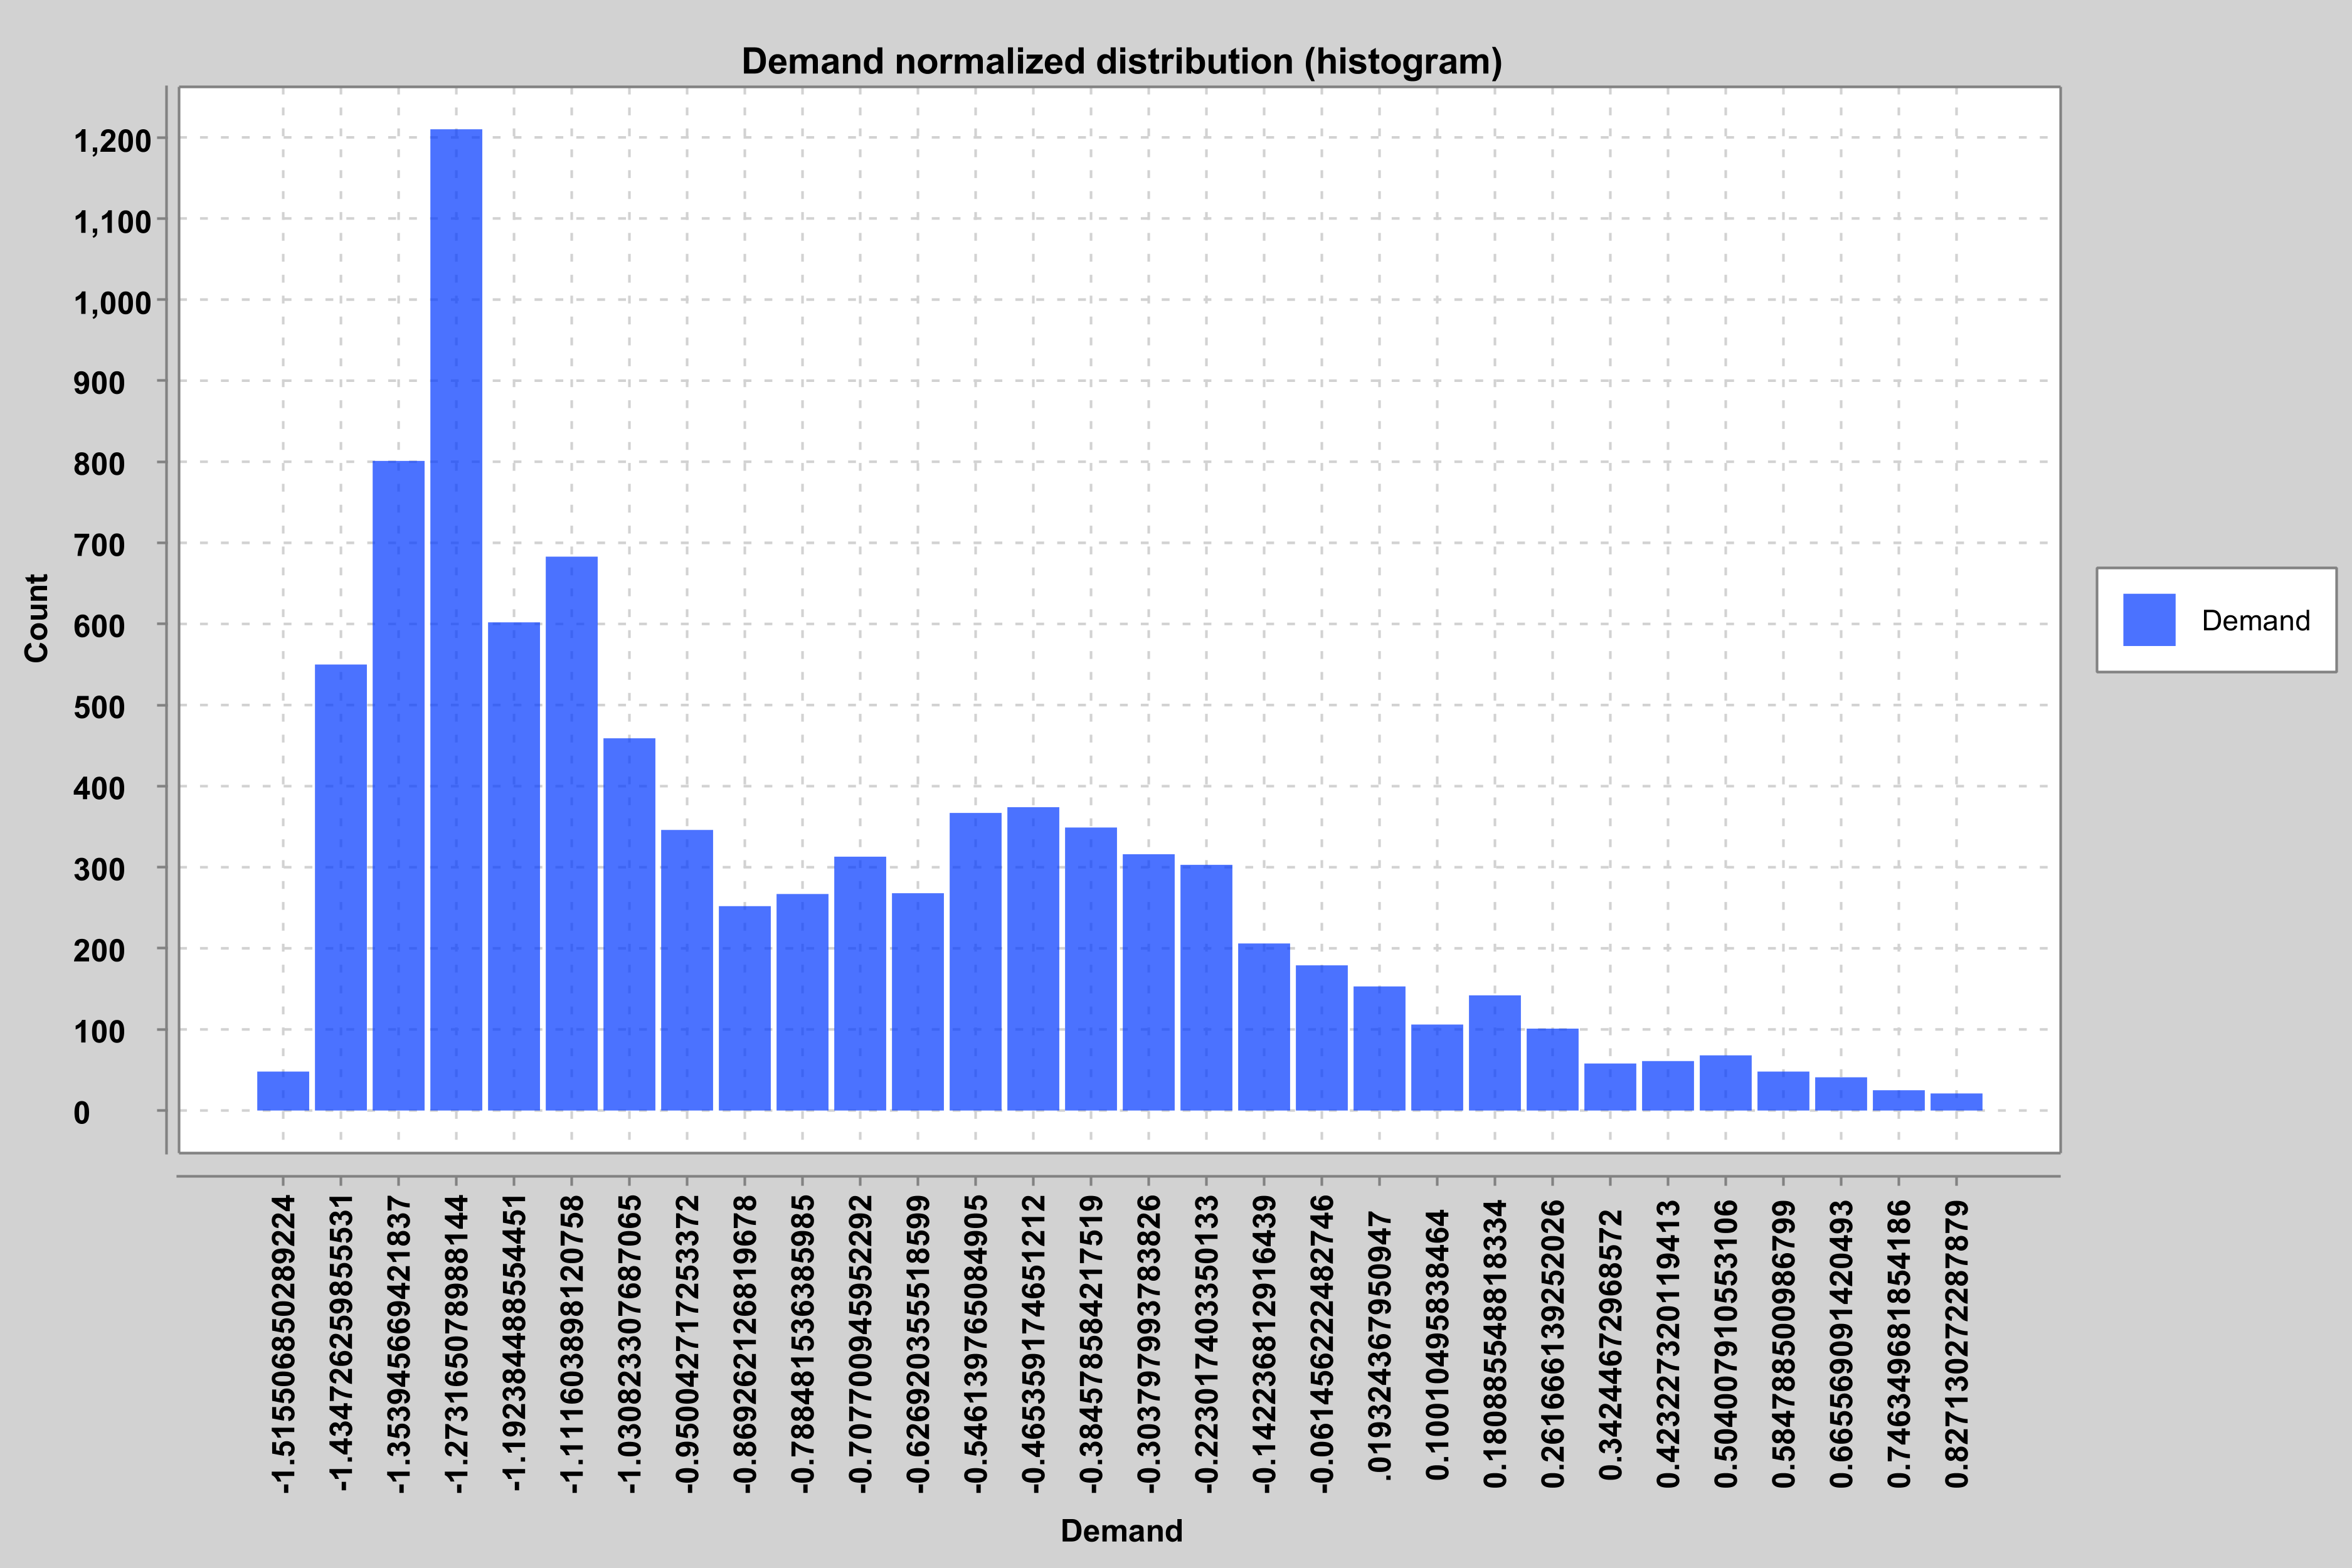

Task 5: Demand vs Temperature Scatter


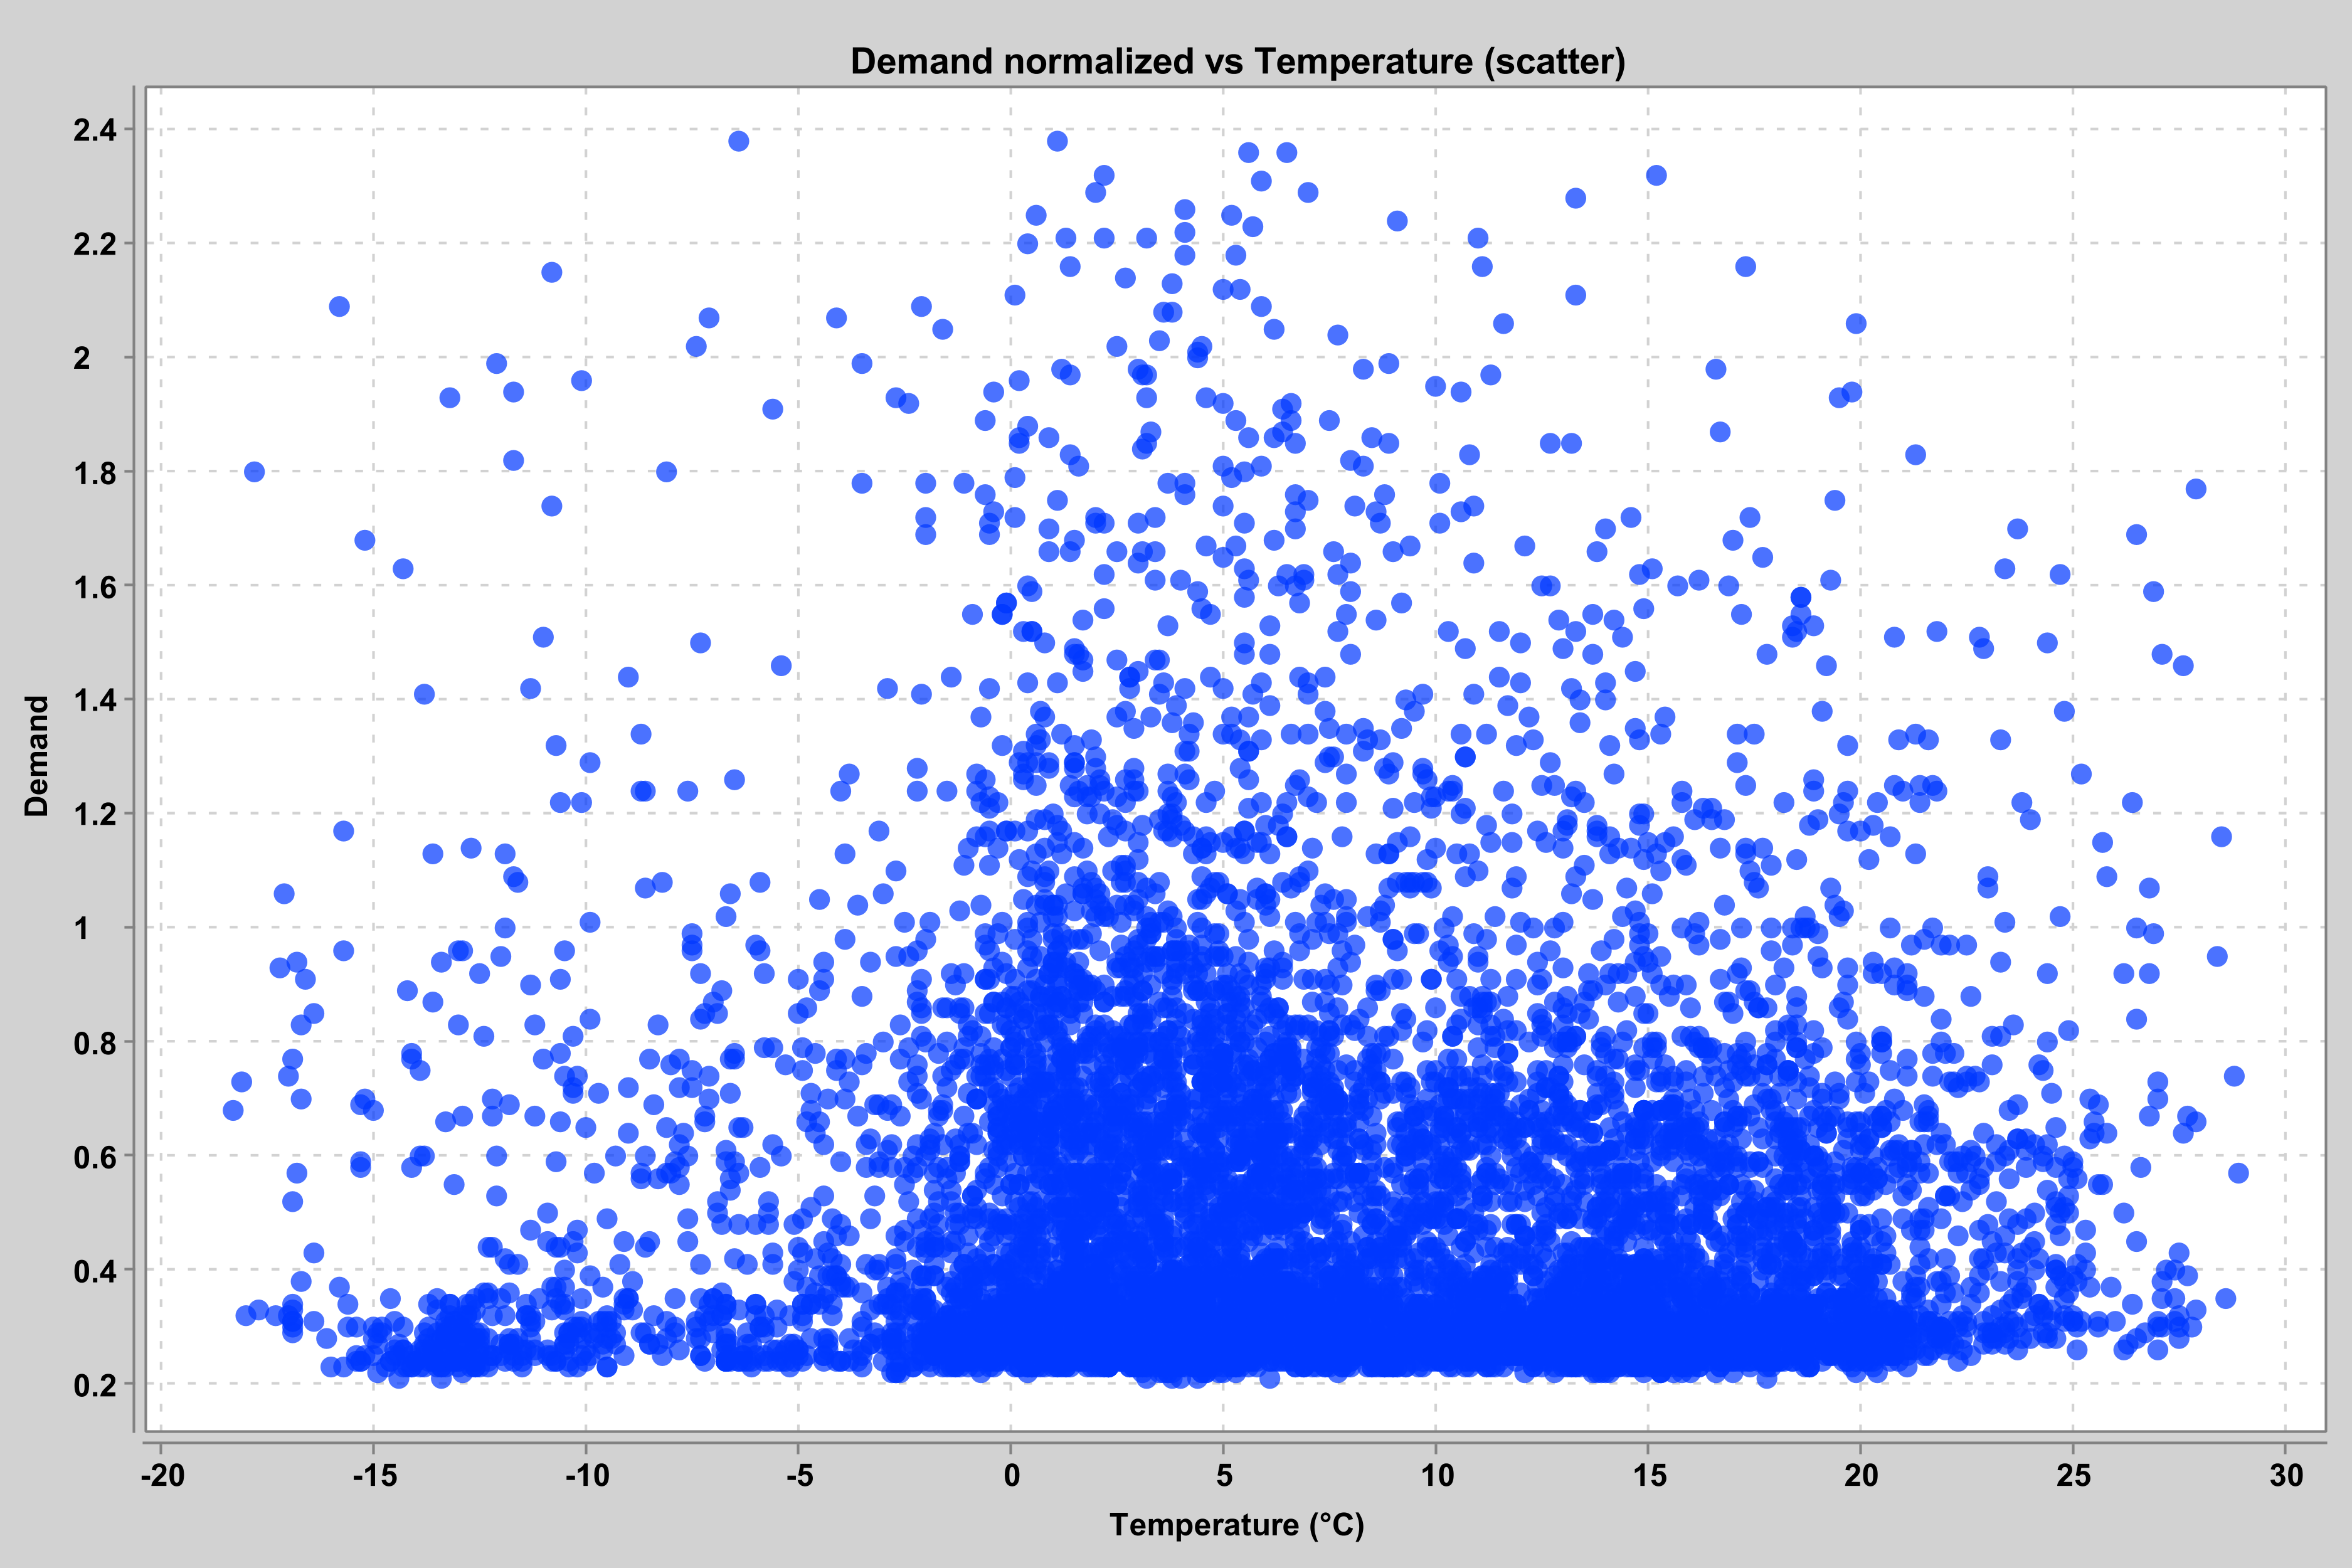

In [5]:
print("Task 5: Demand Histogram")
show_image('task5_histogram_demand.png')

print("Task 5: Demand vs Temperature Scatter")
show_image('task5_scatter_demand_vs_temperature.png')

## Task 6: Decomposition

Classical additive decomposition.

### Key Java Implementation (ClassicalDecomposition.java)

```java
// Trend: Moving Average
double[] trend = MovingAverage.centered(observed, window);

// Seasonality: Average detrended by hour
double[] seasonal = new double[n];
for (int i=0; i<n; i++) seasonal[i] = seasonalIndices[i % period];

// Residual
double[] residual = new double[n];
for (int i=0; i<n; i++) residual[i] = observed[i] - trend[i] - seasonal[i];
```

Task 6: Typical Profiles


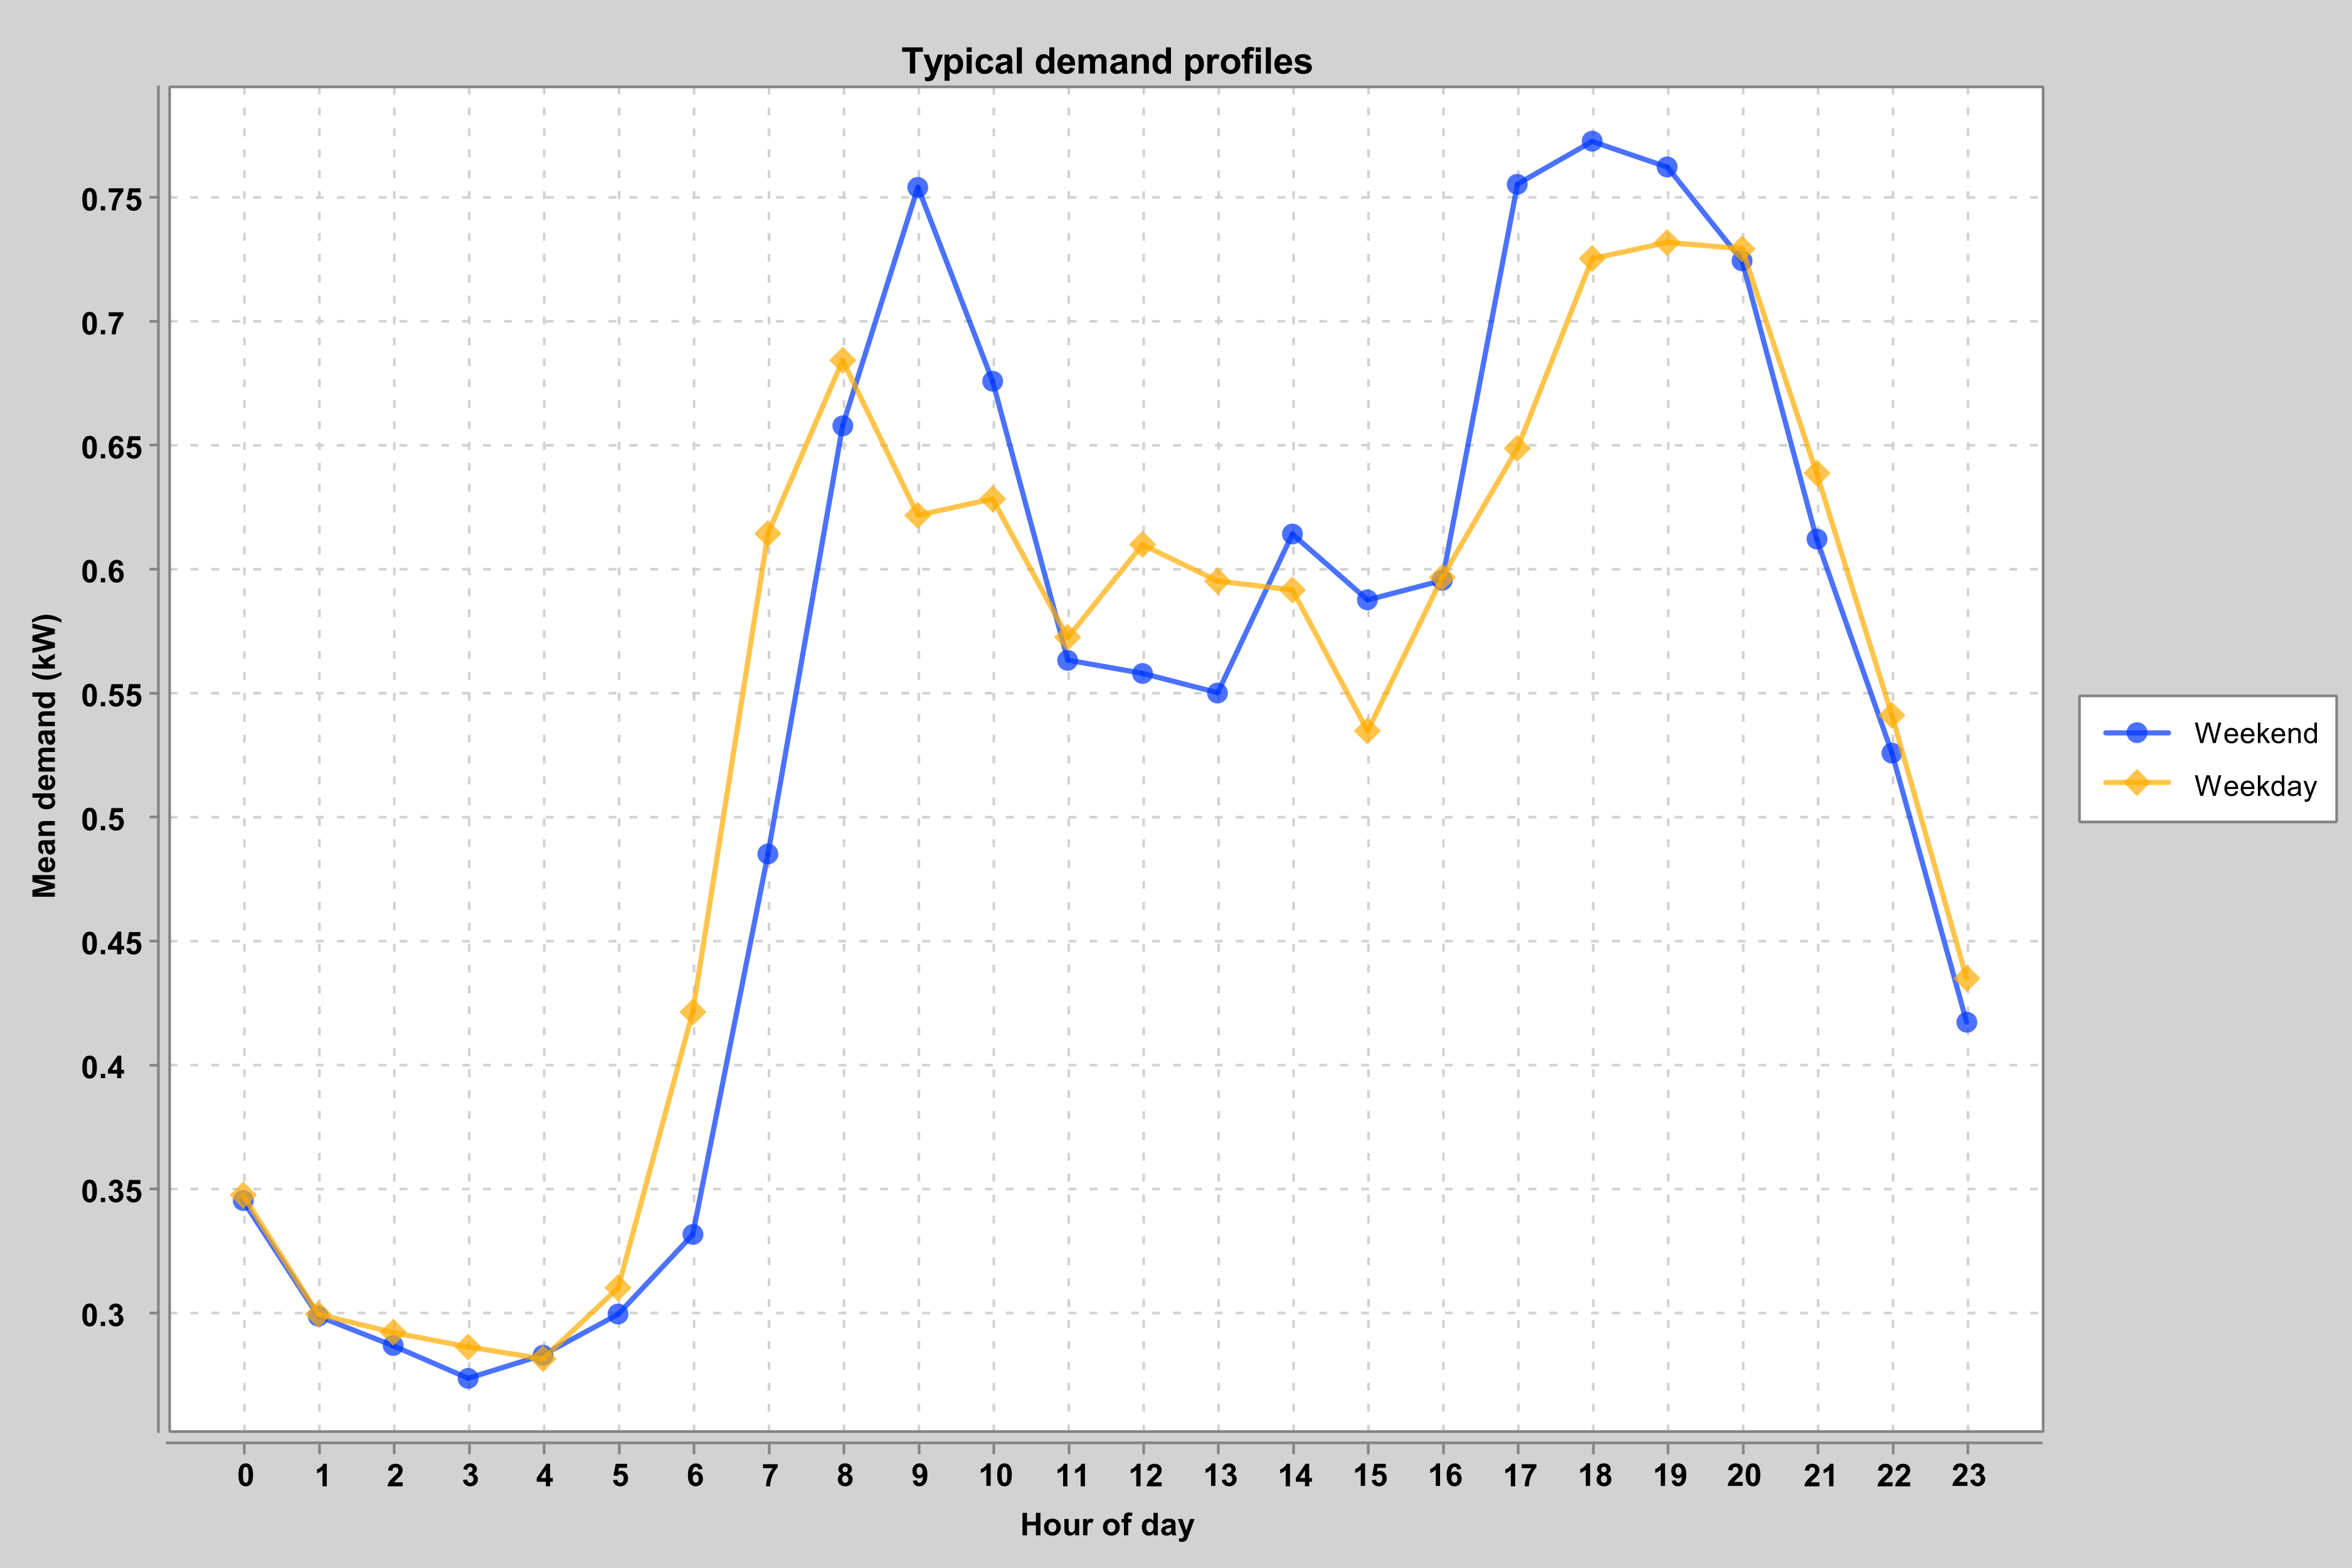

In [6]:
print("Task 6: Typical Profiles")
show_image('task6_typical_profiles.png')

## Task 7: Statistical Modelling (AR)

Autoregressive models on differenced data.

### Key Java Implementation (ArDemandModel.java)

```java
public double[] forecastLevels(double[] yTrain, int steps) {
    var dy = Differencing.diff1(yTrain);
    var phi = fitArOnDiff(dy, order);
    // Forecast diffs and integrate back
    // ...
}
```

Task 7: ACF Plot


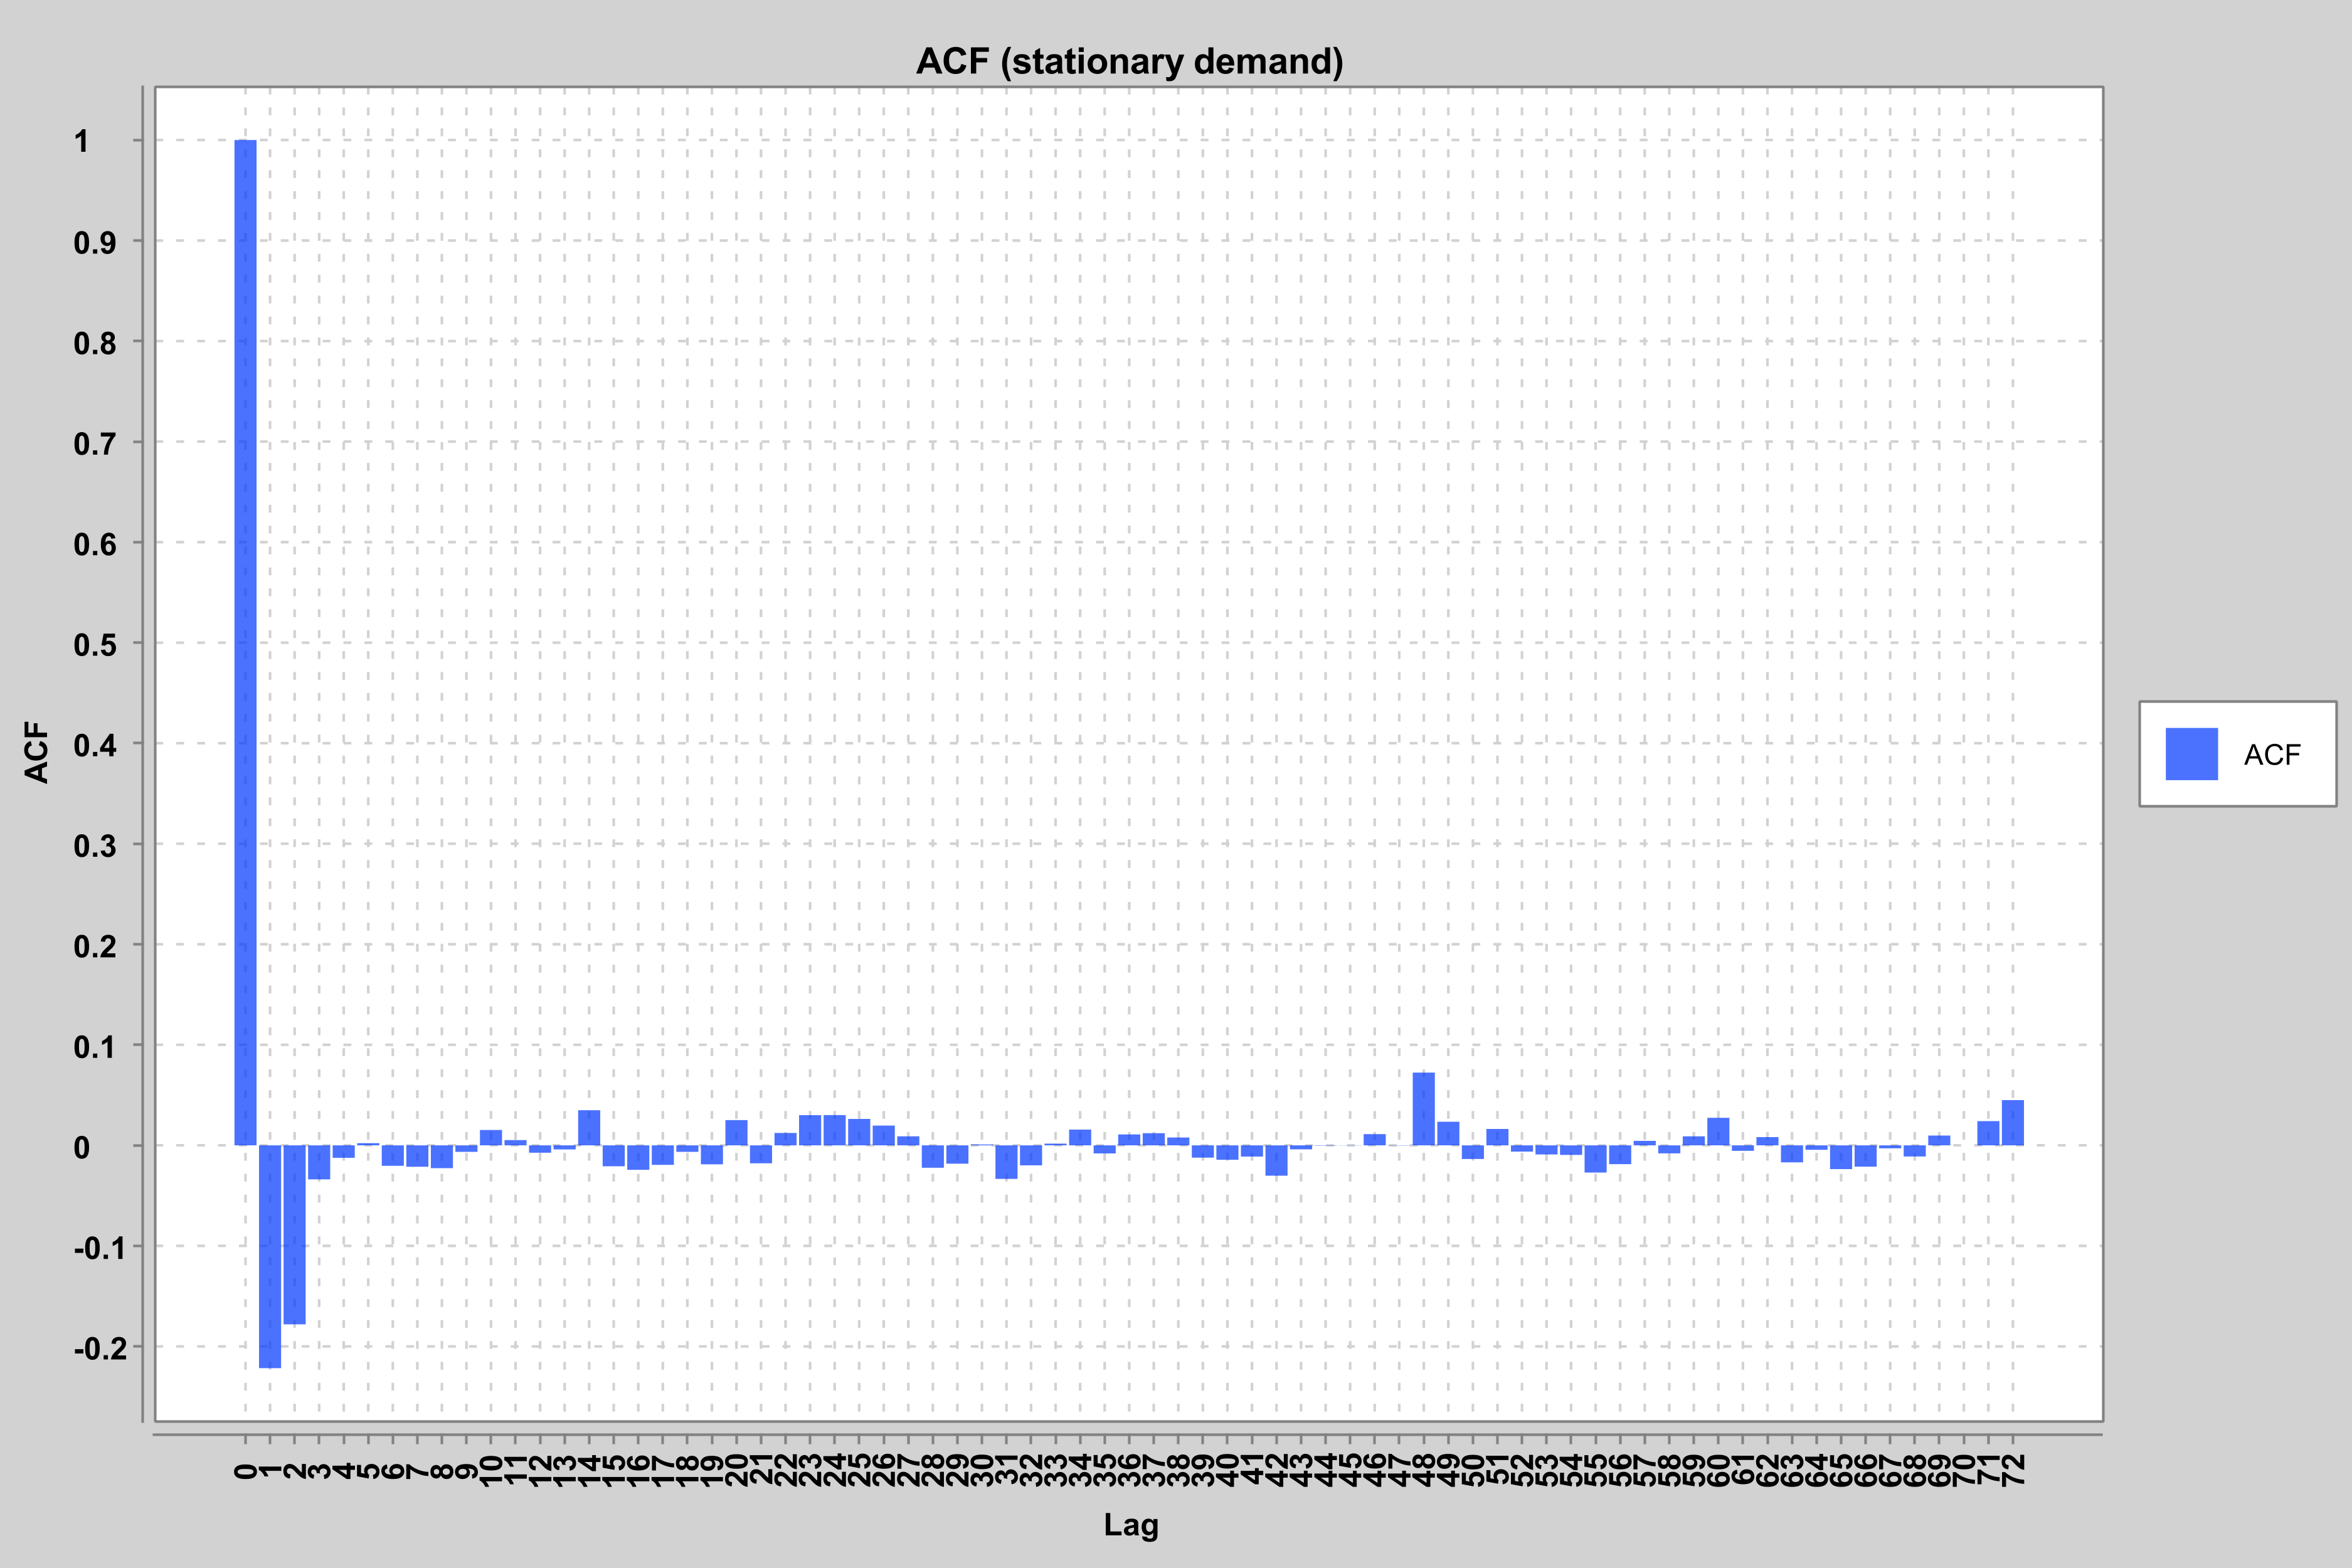

Task 7: PACF Plot


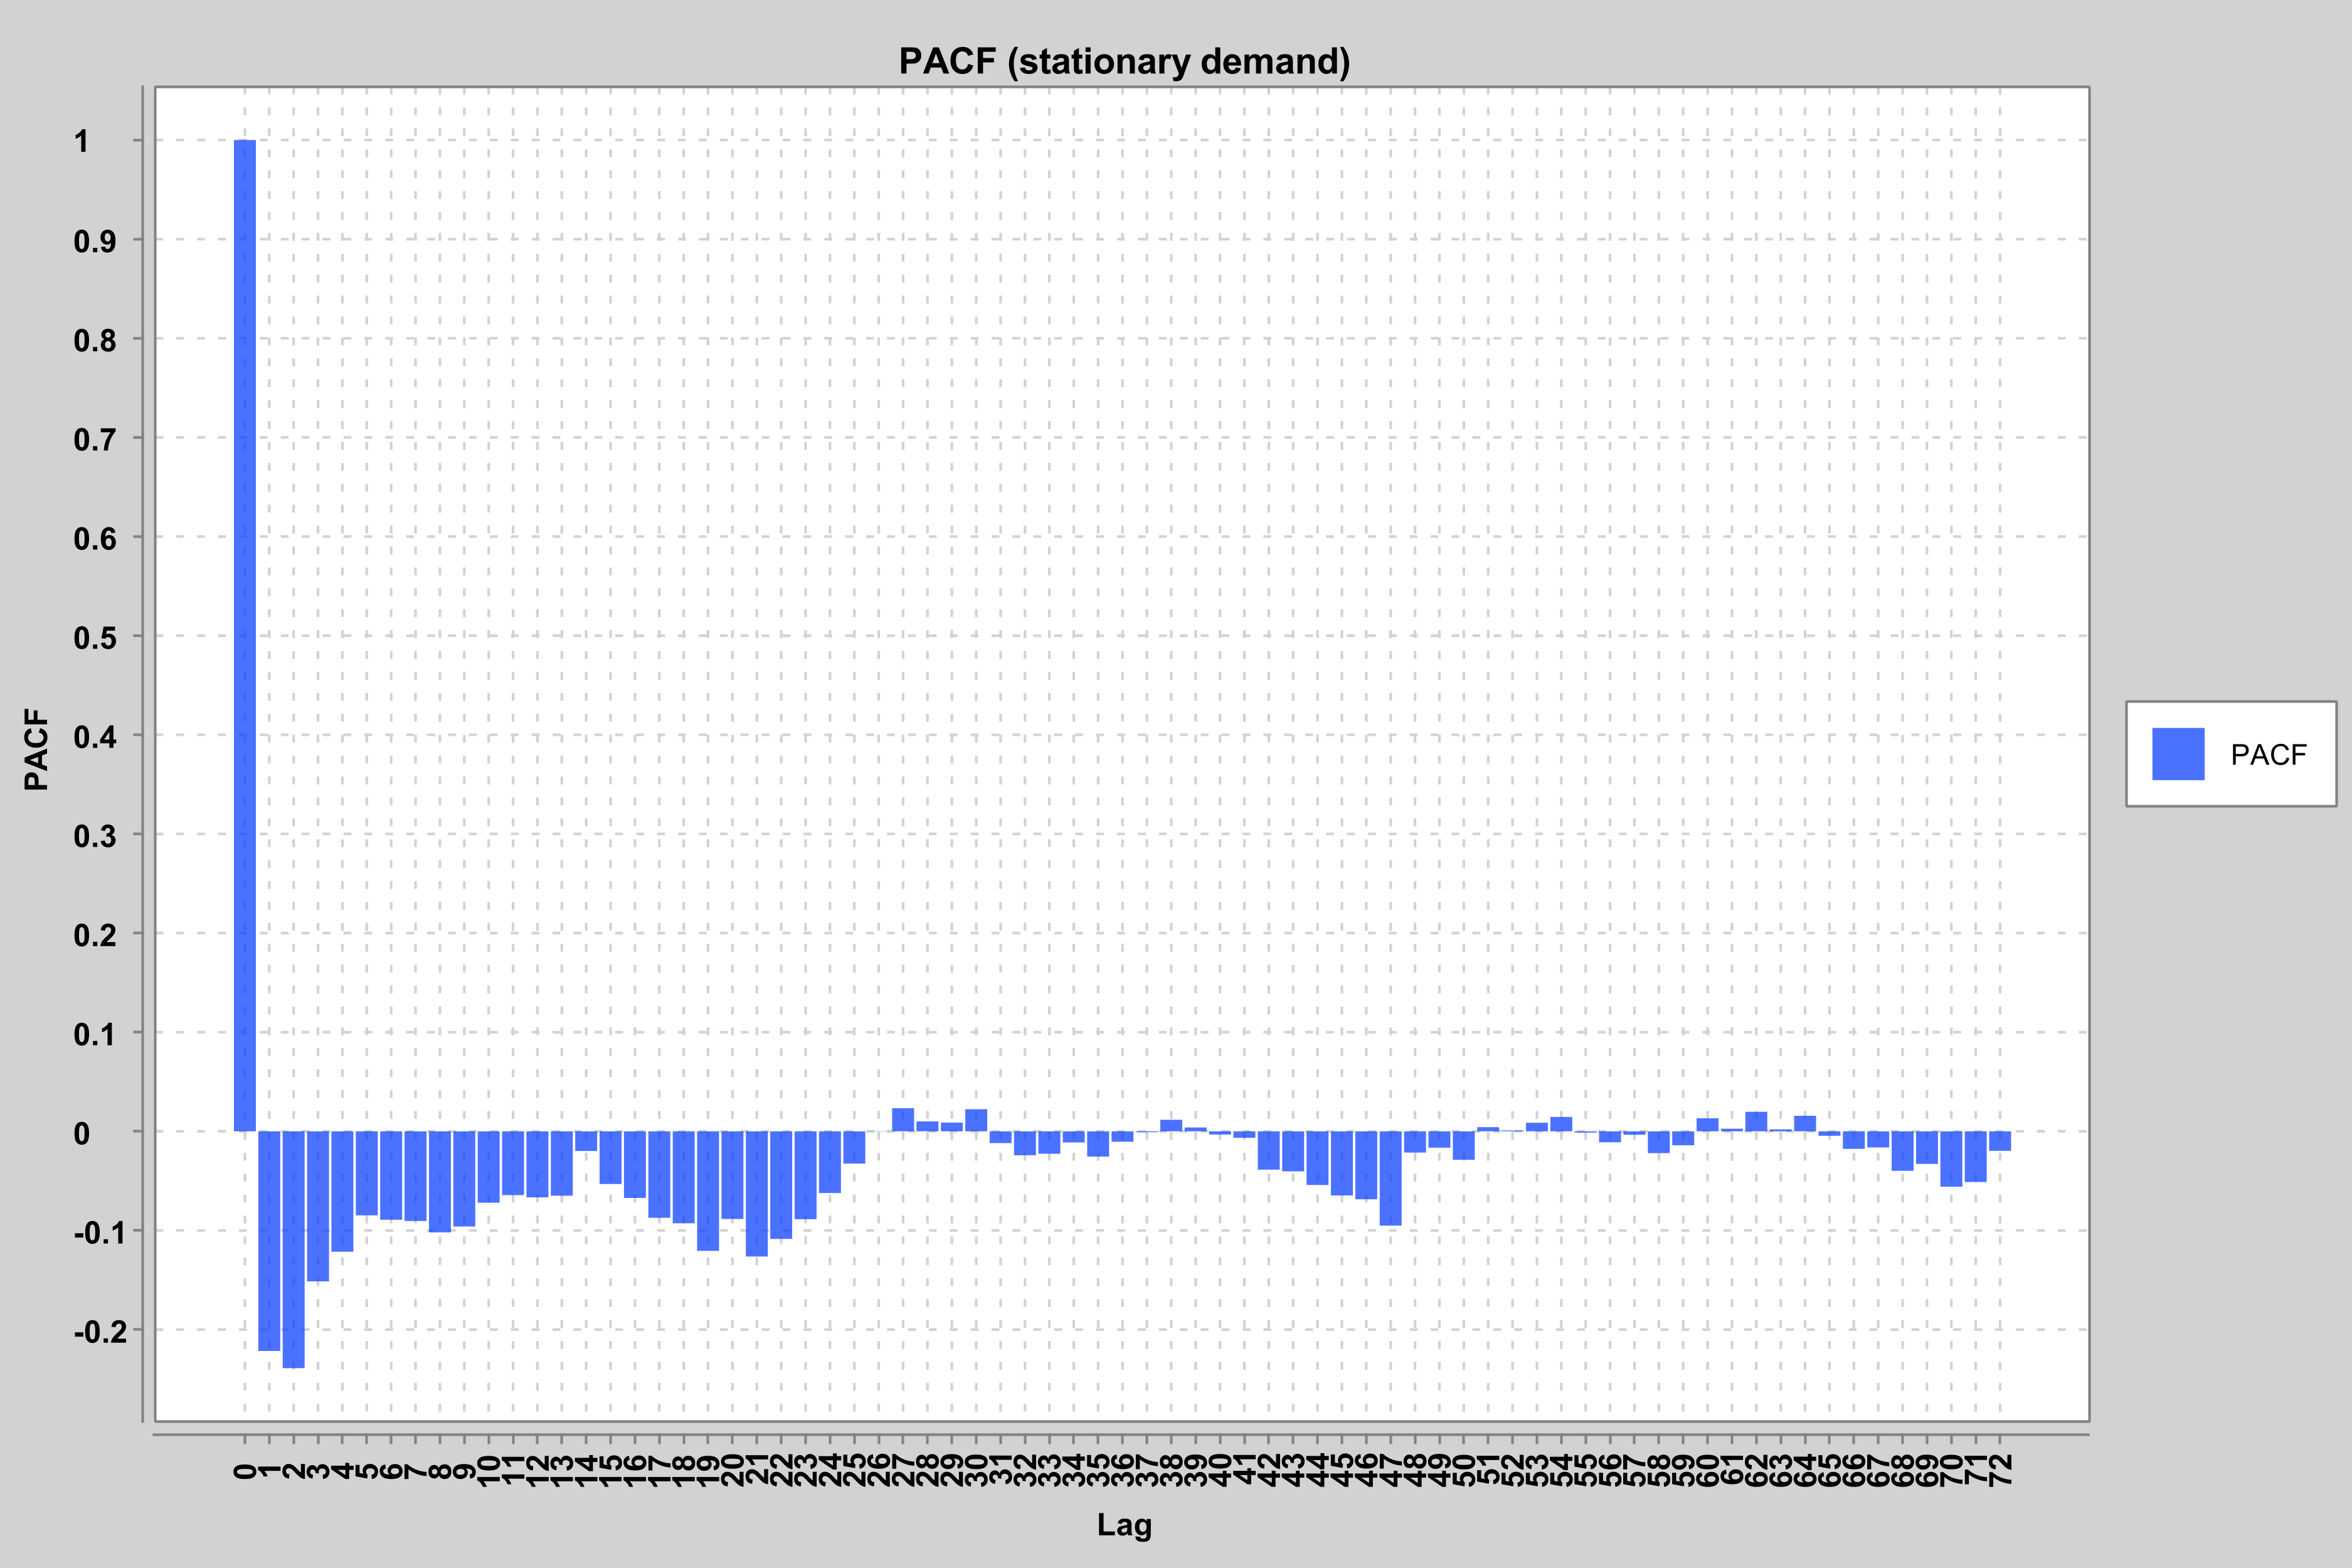

In [7]:
print("Task 7: ACF Plot")
show_image('task7_acf.png')

print("Task 7: PACF Plot")
show_image('task7_pacf.png')

## Task 8: Machine Learning (XGBoost)

Training an XGBoost model with lagged features.

### Key Java Implementation (TrainXgb.java)

```java
public static Booster fit(DemandSupervisedDataset train, DemandSupervisedDataset valid, Task8Config cfg) {
    var params = new HashMap<String, Object>();
    params.put("max_depth", cfg.maxDepth());
    params.put("eta", cfg.eta());
    params.put("objective", "reg:squarederror");
    
    var dtrain = new DMatrix(train.X(), train.y());
    var dvalid = new DMatrix(valid.X(), valid.y());
    
    return XGBoost.train(dtrain, params, cfg.numRounds(), watches, ...);
}
```

## Task 9: Rolling-Origin Forecasting

Evaluating models (AR, XGBoost, Naive) on out-of-sample data.

### Key Java Implementation (RollingDayByDay.java)

```java
public static ForecastReport run(List<Double> history, List<ForecastExoRow> horizon, List<ModelSpec> models, Task9Config cfg) {
    // For each day in horizon
    for (int d = 0; d < days; d++) {
        // Train models on history
        // Forecast next 24 hours
        // Update history with actuals
    }
    return ForecastReport.from(dayResults);
}
```

## Task 10: Models with Exogenous Inputs

Adding weather and time features to AR (ARX) and XGBoost.

### Key Java Implementation (XgbFeaturesExo.java)

```java
public static float[] makeFeatures(PastRow[] lags, ForecastExoRow current, boolean useExo) {
    // Add lag features
    // ...
    if (useExo) {
        x[c++] = (float) current.timestamp().getHour();
        x[c++] = (float) current.temperature();
        x[c++] = (float) current.cloudCover();
        // ...
    }
    return x;
}
```

## Task 11: Optimal Control of Storage

Minimizing cost using battery storage.

### Key Java Implementation (Task11BatteryOptimizer.java)

```java
// Core optimization loop
for (int t = 0; t < n; t++) {
    // Variables
    charge[t] = model.addVariable("ch_" + t).lower(ZERO).upper(bd(battery.chargeLimitKW()));
    gridIn[t] = model.addVariable("gridIn_" + t).lower(ZERO).upper(bd(config.gridLimitKW()));
    
    // Balance Constraint
    model.addExpression("balance_" + t)
        .level(bd(demand))
        .set(gridIn[t], ONE).set(pvUsed[t], ONE).set(discharge[t], ONE)
        .set(charge[t], ONE.negate()).set(gridOut[t], ONE.negate());

    // Objective
    obj.set(gridIn[t], bd(price));
    obj.set(gridOut[t], bd(-config.exportPriceFactor() * price));
}
```

### Results Analysis (Load CSV)

In [8]:
try:
    import pandas as pd
except Exception as e:
    pd = None
    print(f"pandas not available: {e}")

if pd is not None:
    try:
        df_low = pd.read_csv("../figures/task11_schedule_pv_low.csv")
        print("--- PV LOW SCENARIO ---")
        print(df_low.head())
    except Exception as e:
        print(f"Could not load PV Low file: {e}")

    try:
        df_high = pd.read_csv("../figures/task11_schedule_pv_high.csv")
        print("\n--- PV HIGH SCENARIO ---")
        print(df_high.head())
    except Exception as e:
        print(f"Could not load PV High file: {e}")
else:
    print('Skipping CSV load: pandas is not installed in this environment.')


--- PV LOW SCENARIO ---
           timestamp    price  pv_forecast  demand_forecast  pv_used  \
0  2014-07-08T00:00Z  0.06096          0.0         0.385027      0.0   
1  2014-07-08T01:00Z  0.07006          0.0         0.349313      0.0   
2  2014-07-08T02:00Z  0.07005          0.0         0.350694      0.0   
3  2014-07-08T03:00Z  0.05500          0.0         0.356992      0.0   
4  2014-07-08T04:00Z  0.05757          0.0         0.430227      0.0   

   grid_import  grid_export    charge  discharge       soc  
0     5.000000          0.0  4.614973   0.000000  5.000000  
1     0.349313          5.0  0.000000   5.000000  9.384225  
2     2.621145          5.0  0.000000   2.729549  4.121067  
3     5.000000          0.0  4.643008   0.000000  1.247858  
4     5.000000          0.0  4.569773   0.000000  5.658715  

--- PV HIGH SCENARIO ---
           timestamp    price  pv_forecast  demand_forecast  pv_used  \
0  2014-07-08T00:00Z  0.06096          0.0         0.385027      0.0   
1  2014